## Sentiment Analysis for Whispr

1. import data from google sheets
2. clean dataset and create synthetic variables
3. summarize dataset: how many records per category, reviews over time
4. evaluate sentiment of review, give confidence interval
5. calculate summary insights: average sentiment / subjectivity per item, reviews per item
6. compare against manual evaluation
7. export data to google sheets

In [1]:
import pandas as pd
import numpy as np
import os
from textblob import TextBlob
import gspread
from datetime import datetime
from oauth2client.service_account import ServiceAccountCredentials
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

### 1. Import data from GS
- connect to google sheets API
- create spreadsheet and worksheet objects, explore GSpread library
- create dataframe of reviews

In [2]:
#1 define the scope of your access tokens
scope = ['https://www.googleapis.com/auth/drive','https://spreadsheets.google.com/feeds']

#2 after getting oauth2 credentials in a json, obtain an access token from google authorization server
#by creating serviceaccountcredentials and indicating scope, which controls resources / operations that an
#access token permits
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)

#3 log into the google API using oauth2 credentials
#returns gspread.Client instance
c = gspread.authorize(creds)

In [3]:
#create spreadsheet instance
spreadsheet = c.open('UK Sentiment')

#create worksheet instance
worksheet = spreadsheet.worksheet('UK_Reviews')

#get list of dictionaries from worksheet contents
records = worksheet.get_all_records()

#create dataframe from this list of dictionaries
reviews = pd.DataFrame(records)
columns_to_keep = ['review_rating',
                  'review_datedate',
                  'review_headline',
                  'review_size_info',
                  'Review']
clean_reviews = reviews[columns_to_keep]

In [18]:
clean_reviews.head(2)

,review_rating,review_datedate,review_headline,review_size_info,Review,rating,datestamp,clean_headline
0,5.0 out of 5 stars,2 November 2017,A very tasty and well-balanced treat,Flavour Name: Dark Chocolate Nuts and Sea Salt,"I really like these bars, and so do the other ...",5,2017-11-02,Dark Chocolate Nuts and Sea Salt
1,5.0 out of 5 stars,4 August 2019,Great size snack for those of us wanting a hea...,Flavour Name: Dark Chocolate Nuts and Sea Salt,I purchased these because I’m on the 16:8 IF d...,5,2019-08-04,Dark Chocolate Nuts and Sea Salt


### 2. Data preprocessing

In [6]:
#create numeric rating column
strip = lambda x: int(x[0])
clean_reviews['rating'] = clean_reviews['review_rating'].apply(strip)

#create timestamp from review date
dates = lambda x: datetime.strptime(x, '%d %B %Y')
clean_reviews['datestamp'] = clean_reviews['review_datedate'].apply(dates)

#create shortened object name
test = lambda x: x.split(': ')[-1]
clean_reviews['clean_headline'] = clean_reviews['review_size_info'].apply(test)

final_clean = clean_reviews[['rating','datestamp','clean_headline','review_headline','Review']]

#format columns
final_clean.rename(columns={'clean_headline':'Item_Name'}, inplace = True) 
final_clean.columns = map(str.capitalize,final_clean.columns)

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

### 3. Exploratory Analysis
- histogram of ratings
- average / median / max / count of ratings per item type
- overlay ratings with count graph

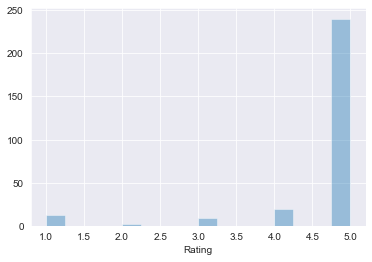

In [59]:
sns.set_style('darkgrid')
sns.distplot(final_clean['Rating'],kde = False)

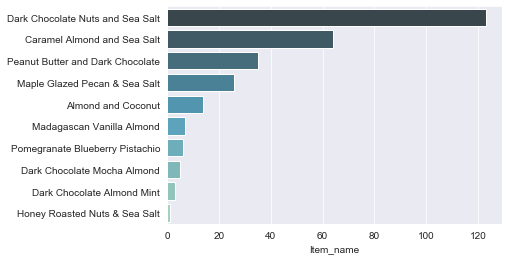

In [54]:
items = pd.DataFrame(final_clean['Item_name'].value_counts())
sns.barplot(items['Item_name'],items.index,palette = "GnBu_d")

In [93]:
summary = (final_clean.groupby('Item_name')['Rating']
     .agg({'avg':np.mean,'median':np.median, 'min':np.min, 'count':len})
     .sort_values(by = 'count', ascending = False))

summary

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


,avg,median,min,count
Item_name,,,,
Dark Chocolate Nuts and Sea Salt,4.544715,5,1,123
Caramel Almond and Sea Salt,4.859375,5,3,64
Peanut Butter and Dark Chocolate,4.628571,5,1,35
Maple Glazed Pecan & Sea Salt,4.846154,5,1,26
Almond and Coconut,4.785714,5,2,14
Madagascan Vanilla Almond,4.142857,5,1,7
Pomegranate Blueberry Pistachio,4.833333,5,4,6
Dark Chocolate Mocha Almond,4.200000,5,2,5
Dark Chocolate Almond Mint,5.000000,5,5,3


### 4. Text analysis
- Calculate polarity (pos vs. negative) and subjectivity (fact vs. opinion) for each review & review headline
- Calculate summary stats of results: average sentiment per category, over time, etc

In [101]:
pol = lambda x: TextBlob(x).polarity
final_clean['headline_pol'] = final_clean['Review_headline'].apply(pol)
final_clean['review_pol'] = final_clean['Review'].apply(pol)

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [102]:
final_clean

,Rating,Datestamp,Item_name,Review_headline,Review,headline_pol,review_pol
0,5,2017-11-02,Dark Chocolate Nuts and Sea Salt,A very tasty and well-balanced treat,"I really like these bars, and so do the other ...",0.200000,0.266641
1,5,2019-08-04,Dark Chocolate Nuts and Sea Salt,Great size snack for those of us wanting a hea...,I purchased these because I’m on the 16:8 IF d...,0.712500,0.295278
2,5,2019-08-20,Dark Chocolate Nuts and Sea Salt,Price varies a lot !!!,These are great bars. I find when I'm training...,0.000000,0.298889
3,5,2019-09-07,Dark Chocolate Almond Mint,Possibly the best tasting healthiest snack bar...,Not a protein bar but a very health-designed s...,0.500000,0.192861
4,5,2019-05-09,Dark Chocolate Nuts and Sea Salt,Definitely a bar to try and enjoy,So good and actually quite low in sugar all co...,0.200000,0.400000
...,...,...,...,...,...,...,...
279,5,2019-12-09,Caramel Almond and Sea Salt,delicious,The price- a little too high.,1.000000,-0.013750
280,5,2019-12-08,Dark Chocolate Nuts and Sea Salt,Healthy Snack,These are filling without too much sweetness. ...,0.500000,0.350000
281,5,2019-12-08,Maple Glazed Pecan & Sea Salt,Super,Super bars nice they are not chocolatey! Only ...,0.333333,0.156667
282,4,2019-12-09,Dark Chocolate Nuts and Sea Salt,A nutty bar as a nice alternative to a chocola...,This product is a tasty nut snack.,0.600000,0.000000
